# Importing libraries

In [ ]:
import os
import numpy as np
np.set_printoptions(suppress=True)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score ,r2_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image


from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import SGD




# Importing the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading csv
dataset = pd.read_csv(r'/content/drive/MyDrive/Projet/daily/data/dataset_btc.csv',sep=',' )
dataset=dataset[:]

In [ ]:
print(dataset.columns)

Index(['date', 'close', 'volubtc', 'tradecount', 'senkou_span_b', 'MACD',
       'Day_dif', 'Close_off_high', 'Volatility', 'close_t-7',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_apple',
       'fng_value'],
      dtype='object')



# Parameter settings

In [ ]:


# number of total past observations from the original dataset to be considered
n_past_total =310  

# number of past observations to be considered for the LSTM training and prediction
n_past = 7

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 1

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'softsign'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 2

# number of neurons of the hidden layers
n_neurons = 64

# patience for the early stopping (number of epochs)
patience = 5

# optimizer (adam, RMSprop)
# lr=0.02
# momentum=0.9
optimizer='adam'# SGD(lr=lr, momentum=momentum)##
# batch size
batch_size=1

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)

features = [   'close', 'volubtc', 'tradecount', 'senkou_span_b', 'MACD',
       'Day_dif', 'Close_off_high', 'Volatility', 'close_t-7',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_apple',
       'fng_value']
'''    
features = ['close']
   '''
# number of inputs features (if higher than 1, )
n_features = len(features)


# EDA (brief)

In [ ]:
dataset=dataset[1000:]


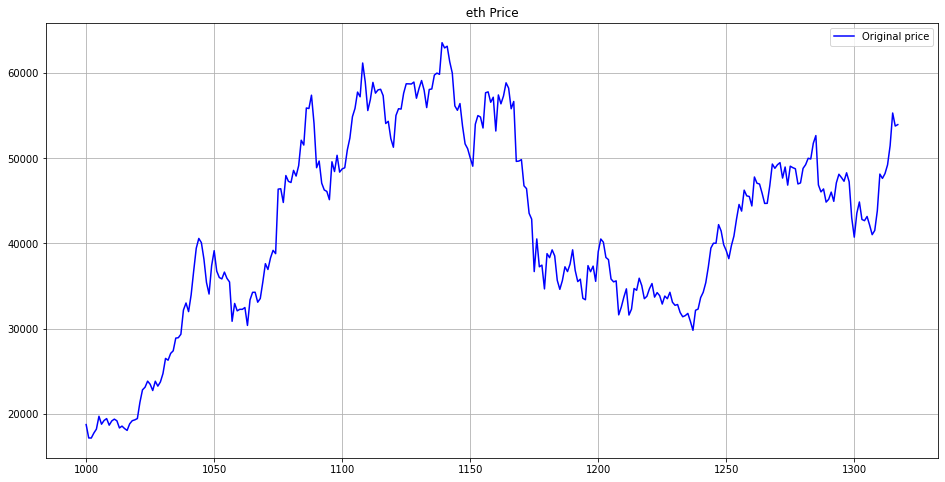

In [ ]:

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(dataset["close"], color='blue', label='Original price')

plt.title(' eth Price ')
plt.grid()
plt.legend()

In [ ]:
# checking for nulls
dataset.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 1000 to 1317
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            318 non-null    object 
 1   close           318 non-null    float64
 2   volubtc         318 non-null    float64
 3   tradecount      318 non-null    float64
 4   senkou_span_b   318 non-null    float64
 5   MACD            318 non-null    float64
 6   Day_dif         318 non-null    float64
 7   Close_off_high  318 non-null    float64
 8   Volatility      318 non-null    float64
 9   close_t-7       318 non-null    float64
 10  miners-revenue  318 non-null    float64
 11  TrendGoogle     318 non-null    float64
 12  open_microsoft  318 non-null    float64
 13  open_apple      318 non-null    float64
 14  fng_value       318 non-null    float64
dtypes: float64(14), object(1)
memory usage: 37.4+ KB


In [ ]:
dataset

,date,close,volubtc,tradecount,senkou_span_b,MACD,Day_dif,Close_off_high,Volatility,close_t-7,miners-revenue,TrendGoogle,open_microsoft,open_apple,fng_value
1000,2020-11-25,18719.110,93266.577,1785408.000,11920.245,1340.470,-0.023,0.555,0.051,17776.120,17988301.561,29.586,2093.799,55.475,94.000
1001,2020-11-26,17149.470,181005.247,2770483.000,12085.415,1182.777,-0.084,0.295,0.146,17802.820,17988301.561,31.276,2093.799,55.475,93.000
1002,2020-11-27,17139.520,85297.025,1572299.000,12118.410,1044.955,-0.001,-0.376,0.059,18655.670,17988301.561,30.793,2093.799,55.475,86.000
1003,2020-11-28,17719.850,64910.700,1209385.000,12118.410,971.361,0.034,-0.683,0.059,18703.800,14684437.137,27.897,2270.363,57.238,87.000
1004,2020-11-29,18184.990,55329.016,1141289.000,12118.410,939.738,0.026,-0.585,0.048,18414.430,14684437.137,27.172,2270.363,57.238,89.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,2021-10-04,49224.940,46796.494,1437692.000,41099.000,231.138,0.021,-0.765,0.055,42147.350,52076953.338,21.000,1905.720,166.626,54.000
1314,2021-10-05,51471.990,52125.668,1641651.000,41099.000,666.401,0.046,-0.711,0.058,41026.540,52076953.338,19.000,1905.720,166.626,59.000
1315,2021-10-06,55315.000,79877.545,2443126.000,41201.305,1306.389,0.075,-0.838,0.104,41524.280,41966394.782,30.000,2333.567,149.865,68.000
1316,2021-10-07,53785.220,54917.378,1703147.000,42314.000,1670.882,-0.028,0.566,0.036,43824.100,41966394.782,28.000,2333.567,149.865,76.000


In [ ]:
# checking the main parameters
dataset.describe()

,close,volubtc,tradecount,senkou_span_b,MACD,Day_dif,Close_off_high,Volatility,close_t-7,miners-revenue,TrendGoogle,open_microsoft,open_apple,fng_value
count,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000,318.000
mean,42000.471,78376.902,1904510.755,36906.617,679.993,0.004,-0.130,0.072,41274.991,41175078.770,31.969,1916.582,154.566,59.978
std,11375.715,39055.638,699545.727,12966.403,2107.043,0.044,0.561,0.040,11792.112,13460448.274,24.189,328.243,50.149,26.837
min,17139.520,26681.064,760979.000,11920.245,-5073.279,-0.144,-0.993,0.018,17139.520,14684437.137,0.000,1023.291,53.530,10.000
25%,34228.057,52345.178,1475727.750,29247.475,-847.390,-0.021,-0.627,0.045,33681.087,31908499.941,19.000,1690.559,118.145,28.000
50%,42740.605,71256.037,1812271.500,39517.520,995.818,0.003,-0.132,0.060,40798.420,41597532.992,22.939,1971.087,157.873,71.000
75%,49897.092,88734.756,2241900.250,45768.003,2022.822,0.028,0.321,0.089,49620.247,52705962.506,43.818,2168.558,187.065,79.000
max,63575.000,354347.243,6331062.000,55892.000,5248.182,0.195,0.999,0.317,63575.000,70637245.505,160.000,2504.575,300.311,95.000


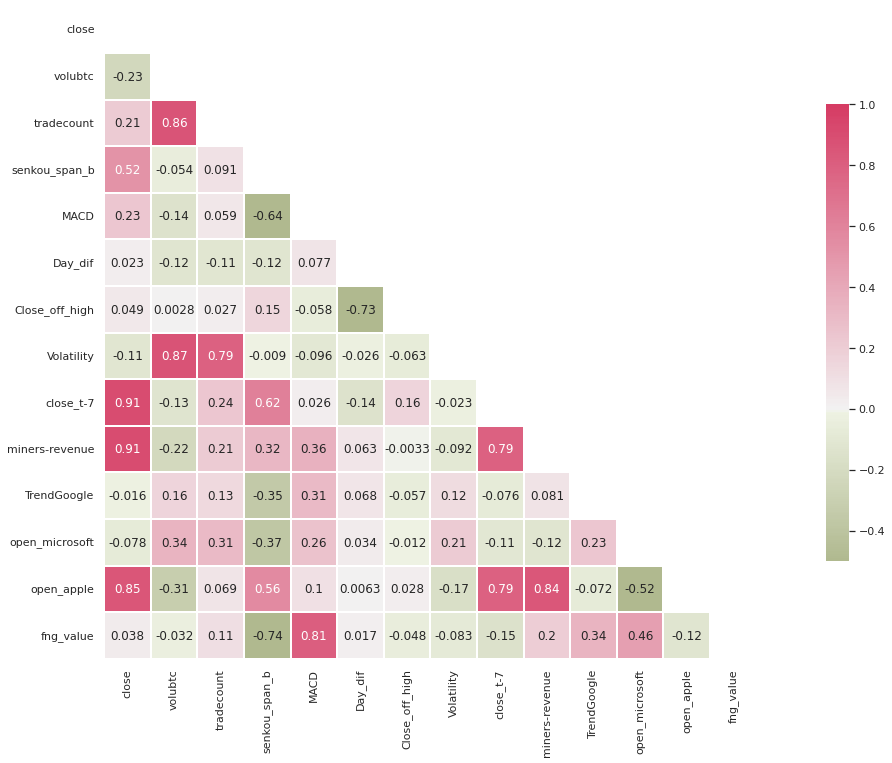

In [ ]:
# looking at the correlation of the main possible variables
'''dataset[[ 'close', 'volubtc', 'tradecount', 'senkou_span_b', 'MACD',
       'Day_dif', 'Close_off_high', 'Volatility', 'close_t-7',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_apple',
       'fng_value']].corr()'''




import matplotlib.pyplot as plt
import seaborn as sns



sns.set_theme(style="white")




# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(98, 2, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-0.5, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .7},annot=True)

In [ ]:
dataset.info()


df=dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 1000 to 1317
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            318 non-null    object 
 1   close           318 non-null    float64
 2   volubtc         318 non-null    float64
 3   tradecount      318 non-null    float64
 4   senkou_span_b   318 non-null    float64
 5   MACD            318 non-null    float64
 6   Day_dif         318 non-null    float64
 7   Close_off_high  318 non-null    float64
 8   Volatility      318 non-null    float64
 9   close_t-7       318 non-null    float64
 10  miners-revenue  318 non-null    float64
 11  TrendGoogle     318 non-null    float64
 12  open_microsoft  318 non-null    float64
 13  open_apple      318 non-null    float64
 14  fng_value       318 non-null    float64
dtypes: float64(14), object(1)
memory usage: 37.4+ KB


In [ ]:
# use close only and fill NaN with ffil
df = dataset.set_index('date')[features]#.tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)



# Preprocessing the data

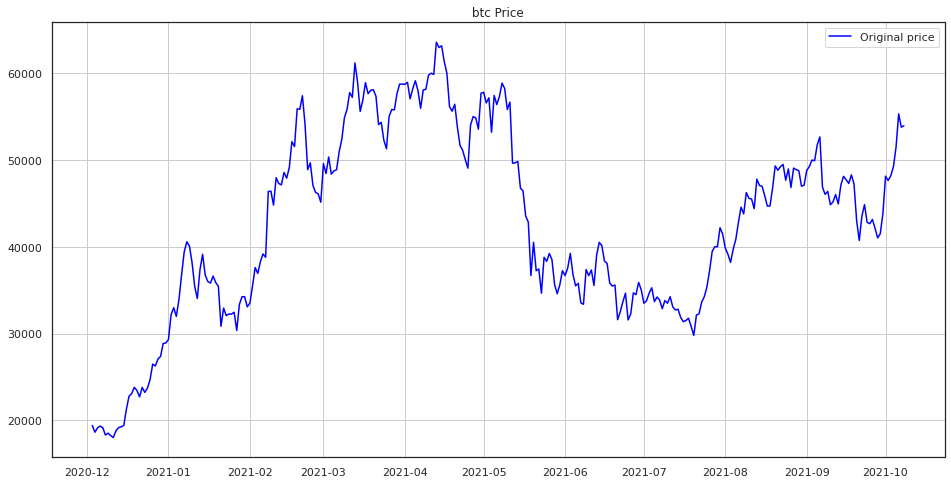

In [ ]:
# droppping firsts observations becuase they may not be representative of BTC behaviour now due to beginnings of crypto market
df = df.tail(n_past_total)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(df["close"], color='blue', label='Original price')

plt.title(' btc Price ')
plt.grid()
plt.legend()

In [ ]:
# train test split
training_set = df
training_set = training_set.values
print('training_set.shape:\t', training_set.shape)

training_set.shape:	 (310, 14)


In [ ]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)



training_set_scaled.shape:  (310, 14)


In [ ]:
# creating a data structure with timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape





((303, 7, 14), (303, 1))

In [ ]:
X_train=X_train[:280]
y_train=y_train[:280]

In [ ]:
X_test = X_train[-1].reshape(1, n_past, n_features)
y_test  = y_train[-1]

X_test

array([[[0.61512343, 0.11715659, 0.18583601, 0.59597223, 0.60557561,
         0.37229424, 0.43969238, 0.14821732, 0.68204313, 0.4677974 ,
         0.44583333, 0.59510462, 0.40886105, 0.43529412],
        [0.62273963, 0.07315554, 0.14481059, 0.59898319, 0.57905099,
         0.44611392, 0.5312422 , 0.07621446, 0.69143508, 0.48042579,
         0.27083333, 0.30560559, 0.57063957, 0.41176471],
        [0.58882918, 0.06826216, 0.14523338, 0.59898319, 0.54533718,
         0.32575205, 0.7518387 , 0.14831297, 0.70764036, 0.48042579,
         0.19583333, 0.30560559, 0.57063957, 0.42352941],
        [0.59591725, 0.01147309, 0.05384318, 0.59898319, 0.5208047 ,
         0.44570254, 0.64245446, 0.03354723, 0.70584217, 0.48042579,
         0.10416667, 0.30560559, 0.57063957, 0.24705882],
        [0.61461683, 0.01652052, 0.0751926 , 0.59898319, 0.50783188,
         0.47949204, 0.25067614, 0.066354  , 0.74549375, 0.60974784,
         0.10416667, 0.38662608, 0.52696971, 0.25882353],
        [0.59080158,

In [ ]:
X_train.shape

(280, 7, 14)

In [ ]:
X_train

array([[[0.03042197, 0.12210088, 0.08639907, ..., 0.8009248 ,
         0.03727926, 0.96470588],
        [0.01348289, 0.13612209, 0.09437525, ..., 0.59296944,
         0.05285984, 0.96470588],
        [0.02439981, 0.04956778, 0.03072575, ..., 0.59296944,
         0.05285984, 0.97647059],
        ...,
        [0.02482231, 0.04483597, 0.01435795, ..., 0.86859109,
         0.        , 0.98823529],
        [0.0063151 , 0.10665087, 0.06861693, ..., 0.86859109,
         0.        , 1.        ],
        [0.01108404, 0.1614585 , 0.09721525, ..., 0.86859109,
         0.        , 0.89411765]],

       [[0.01348289, 0.13612209, 0.09437525, ..., 0.59296944,
         0.05285984, 0.96470588],
        [0.02439981, 0.04956778, 0.03072575, ..., 0.59296944,
         0.05285984, 0.97647059],
        [0.0290495 , 0.03162373, 0.01066465, ..., 0.59296944,
         0.05285984, 1.        ],
        ...,
        [0.0063151 , 0.10665087, 0.06861693, ..., 0.86859109,
         0.        , 1.        ],
        [0.0

In [ ]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape



(280, 7, 14)

# GridSearch





In [ ]:
# Building the RNN

def create_model(activation='relu',learn_rate=0.01, momentum=0,n_neurons=64, optimizer='adam',dropout=0.1,n_layers=1):
  # Initialising the RNN
  regressor = Sequential()

  # Input layer
  regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
  #regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

  # Hidden layers
  for _ in range(n_layers):
      regressor.add(Dropout(dropout))
      regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

  # Last hidden layer (changing the return_sequences)
  regressor.add(Dropout(dropout))
  regressor.add(LSTM(units=n_neurons, return_sequences=False))

  # Adding the output layer
  regressor.add(Dense(units=n_future,))

  # Compiling the RNN
  regressor.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()],
  )


  # Model summary
  regressor.summary()
  return regressor

In [ ]:
'''pip install scikeras'''

'pip install scikeras'

In [ ]:
'''from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import  KerasRegressor

#tu appelles ton model :
model =  KerasRegressor(model=create_model,  verbose=0)

# define the grid search parameters
batch_size = [1,10, 20]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [ 0.2, 0.4]
optimizer = ['SGD', 'Adam',]
activation =  [ 'softsign', 'relu', 'tanh', 'sigmoid']
epochs = [3,7,10]
n_neurons=[32, 64,  128]
dropout=[0, 0.1,  0.2]
n_layers=[1,3,6]

param_grid = dict(epochs=epochs, batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, scoring="r2", error_score="raise")
grid_result = grid.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

'from sklearn import svm, datasets\nfrom sklearn.model_selection import GridSearchCV\nfrom scikeras.wrappers import  KerasRegressor\n\n#tu appelles ton model :\nmodel =  KerasRegressor(model=create_model,  verbose=0)\n\n# define the grid search parameters\nbatch_size = [1,10, 20]\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nmomentum = [ 0.2, 0.4]\noptimizer = [\'SGD\', \'Adam\',]\nactivation =  [ \'softsign\', \'relu\', \'tanh\', \'sigmoid\']\nepochs = [3,7,10]\nn_neurons=[32, 64,  128]\ndropout=[0, 0.1,  0.2]\nn_layers=[1,3,6]\n\nparam_grid = dict(epochs=epochs, batch_size=batch_size)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, scoring="r2", error_score="raise")\ngrid_result = grid.fit(X_train,y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\

# BUILD LSTM

In [ ]:
  # Initialising the RNN
regressor = Sequential()

  # Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
  #regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

  # Hidden layers
for _ in range(n_layers):
   regressor.add(Dropout(dropout))
   regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

  # Last hidden layer (changing the return_sequences)
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False))

  # Adding the output layer
regressor.add(Dense(units=n_future,))

  # Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()],
  )


  # Model summary
regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 7)              616       
                                                                 
 dropout (Dropout)           (None, 7, 7)              0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             18432     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [ ]:
#  Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [ ]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=batch_size
                    , epochs=10
                    , validation_split=0.05
                    , callbacks=[early_stop]
                   )



Epoch 1/10
266/266 [==============================] - 18s 40ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 2/10
266/266 [==============================] - 10s 36ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/10
266/266 [==============================] - 12s 45ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 4/10
266/266 [==============================] - 10s 38ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 5/10
266/266 [==============================] - 13s 50ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/10
266/266 [==============================] - 10s 38ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 7/10
266/2

In [ ]:
# Exporting the regressor
last_date = dataset.date.values[-1]
params = ['reg', last_date, n_past_total, n_past, n_future, activation, n_layers, n_neurons,batch_size ,n_features, patience, optimizer]
modelname = 'output/'
for i in params:
    modelname += str(i)
    if i!= params[-1]:
        modelname += '_'
if not os.path.exists(modelname):
    os.makedirs(modelname)
regressor.save('{}/regressor.h5'.format(modelname))

In [ ]:
list(res.history)

['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']

In [ ]:
# Loads the weights
#regressor.load_weights(checkpoint_path)

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('C:\Users\yonas\output\reg_2021-10-29_700_90_7_softsign_6_64_5_19_25_adam\regressor.h5')



# Validation

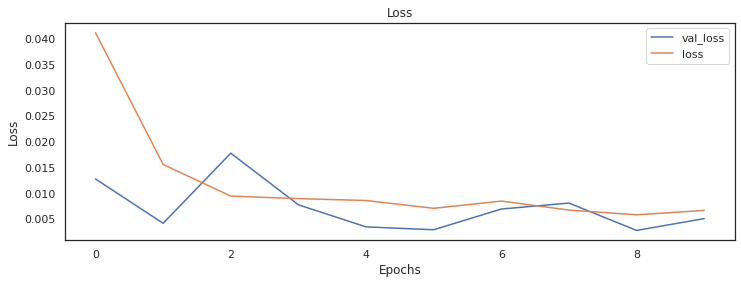

In [ ]:


# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('{}/Loss.png'.format(modelname))
plt.show()



In [ ]:


def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y



In [ ]:
X_test

array([[[0.61512343, 0.11715659, 0.18583601, 0.59597223, 0.60557561,
         0.37229424, 0.43969238, 0.14821732, 0.68204313, 0.4677974 ,
         0.44583333, 0.59510462, 0.40886105, 0.43529412],
        [0.62273963, 0.07315554, 0.14481059, 0.59898319, 0.57905099,
         0.44611392, 0.5312422 , 0.07621446, 0.69143508, 0.48042579,
         0.27083333, 0.30560559, 0.57063957, 0.41176471],
        [0.58882918, 0.06826216, 0.14523338, 0.59898319, 0.54533718,
         0.32575205, 0.7518387 , 0.14831297, 0.70764036, 0.48042579,
         0.19583333, 0.30560559, 0.57063957, 0.42352941],
        [0.59591725, 0.01147309, 0.05384318, 0.59898319, 0.5208047 ,
         0.44570254, 0.64245446, 0.03354723, 0.70584217, 0.48042579,
         0.10416667, 0.30560559, 0.57063957, 0.24705882],
        [0.61461683, 0.01652052, 0.0751926 , 0.59898319, 0.50783188,
         0.47949204, 0.25067614, 0.066354  , 0.74549375, 0.60974784,
         0.10416667, 0.38662608, 0.52696971, 0.25882353],
        [0.59080158,

y_pred:
 [45662.01101659596]
y_true:
 [[53951.43]]


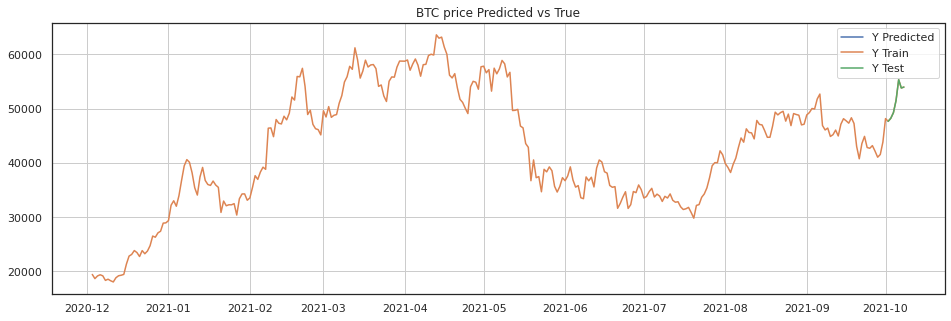

In [ ]:


# Validation

# getting the predictions


y_pred = regressor.predict(X_test).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)
#X_test = 

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['close']].tail(n_future).index, 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']]#.tail(n_future)
y_true = y_true_df.tail(n_future).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())


# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Y Predicted')
plt.plot(y_true_df, label='Y Train')
plt.plot(y_true_df.tail(n_past), label='Y Test')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Validation.png'.format(modelname))
plt.grid()
plt.show()



In [ ]:
listetrue =[]
listepred=[]

for i in range(30,0,-1):
  
  X_test = X_train[-i].reshape(1, n_past, n_features)
  y_test  = y_train[-i]
  y_pred = regressor.predict(X_test).tolist()[0]
  y_pred = dummy_invscaler(y_pred, n_features)
  # creating a DF of the predicted prices
  y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['close']].tail(n_future).index, 
                         columns=df[['close']].columns)
  
  # getting the true values
  y_true_df = df[['close']]#.tail(n_future)
  y_true = y_true_df.tail(i).head(1).values
  '''print('-----------------------------')
  print(i)
  print('y_pred:\n', y_pred.tolist())
  print('y_true:\n', y_true.tolist())'''
  y_true.tolist()
  listetrue.append(y_pred.tolist())
  listepred.append(y_true.tolist())

 

In [ ]:
listepred = np.array(listepred).reshape(30,1)


In [ ]:
# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(listepred, listetrue))
moy = y_true.mean()
Nrmse = rmse/moy
Nrmse

0.0886464034530809

In [ ]:


def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


Mape= mape(listepred, listetrue)
Mape

8.479825928208637

In [ ]:
#Explained variance regression score function.
explained_variance_score(listepred, listetrue)
# Best possible score is 1.0, lower values are worse.

-0.45712408664774706

In [ ]:


# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse



8289.418983404037

In [ ]:


# mean_absolute_error (MaE)
mse = mean_absolute_error(y_true, y_pred)
mse



8289.418983404037

In [ ]:


#Explained variance regression score function.
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.



1.0


# Predictions

y_pred:
 [48966.75796502292]
y_true:
 [[53951.43]]


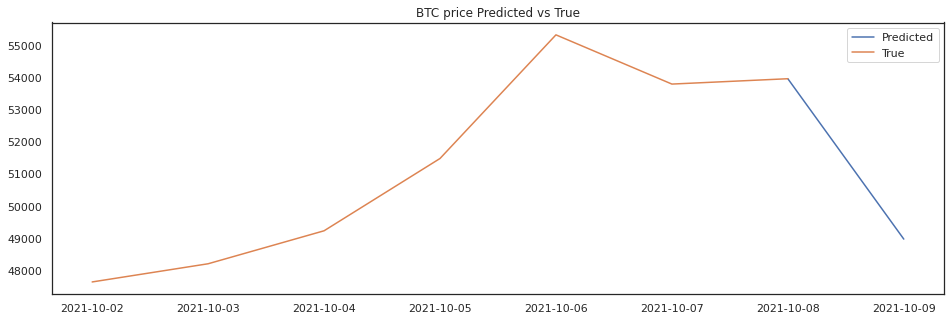

In [ ]:
# Predicting/Forecasting

# getting the predictions
x = df[features][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']].tail(n_past)

# linking them
#y_true_df = y_true_df.append(y_pred_df.head(1))
y_pred_df = y_pred_df.append(y_true_df.tail(1)).sort_index()

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Predictions.png'.format(modelname))
plt.show()

In [ ]:
# export to csv
#y_pred_df.to_csv('{}/preds_{}.csv'.format(modelname,n_future))
# show
y_pred_df

,close
2021-10-08,53951.430
2021-10-09,48966.758


# cross validation

In [ ]:
''x=np.array(x)
y=np.array(y)

for train, test in kfold.split(x,y):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 8))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 8))

    output_size=1 
    neurons=100 
    activ_func="tanh"
    dropout=0.25
    loss="mean_squared_error" 
    optimizer="sgd"
    model = Sequential()
    model.add(LSTM(neurons,return_sequences=True,input_shape=(1,8)))
    model.add(LSTM(90))
 
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer='adam',metrics =["mae"])
    model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))





SyntaxError: ignored

# SHAP

https://medium.datadriveninvestor.com/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
#%tensorflow_version 2.4.0

In [ ]:
X100 = shap.utils.sample(X_test, 100) # 100 instances for use as the background distribution

In [ ]:

# model

model = load_model('regressor.h5')

model.fit(X_train, y_train)

print("Model coefficients:\n")
for i in range(dataset.shape[1]):
    print(dataset.columns[i], "=", model.coef_[i].round(4))

In [ ]:
X_test.shape
X_test=X_test.reshape(7,15)

In [ ]:
X_test.shape

In [ ]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(regressor.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
import shap

model = load_model('regressor.h5')
# Explainability module
Helper.explainable_forecast(dataset, ff_full_features_, fc, specific_prediction_sample_to_explain=df_full_features.shape[0]+2, input_label_index_value=0, num_labels=1)

## lime